In [9]:
from pathlib import Path

import torchio as tio
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np

from model import UNet

In [2]:
def change_img_to_label_path(path):
    """
    Replace data with mask to get the masks
    """
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)


In [3]:
path = Path("Task03_Liver_rs/imagesTr/")
subjects_paths = list(path.glob("liver_*"))
subjects = []

for subject_path in subjects_paths:
    label_path = change_img_to_label_path(subject_path)
    subject = tio.Subject({"CT":tio.ScalarImage(subject_path), "Label":tio.LabelMap(label_path)})
    subjects.append(subject)


In [4]:
for subject in subjects:
    assert subject["CT"].orientation == ("R", "A", "S")


In [5]:
process = tio.Compose([
            tio.CropOrPad((256, 256, 200)),
            tio.RescaleIntensity((-1, 1))
            ])


augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10))


val_transform = process
train_transform = tio.Compose([process, augmentation])


In [6]:
train_dataset = tio.SubjectsDataset(subjects[:105], transform=train_transform)
val_dataset = tio.SubjectsDataset(subjects[105:], transform=val_transform)

sampler = tio.data.LabelSampler(patch_size=96, label_name="Label", label_probabilities={0:0.2, 1:0.3, 2:0.5})


In [7]:
train_patches_queue = tio.Queue(
     train_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=4,
    )

val_patches_queue = tio.Queue(
     val_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=4,
    )



In [8]:
batch_size = 2

train_loader = torch.utils.data.DataLoader(train_patches_queue, batch_size=batch_size, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_patches_queue, batch_size=batch_size, num_workers=0)


In [11]:
class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = UNet()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()

        pred = self(img)
        loss = self.loss_fn(pred, mask)

        # Logs
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss


    def validation_step(self, batch, batch_idx):
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()

        pred = self(img)
        loss = self.loss_fn(pred, mask)

        # Logs
        self.log("Val Loss", loss)
        self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Val")

        return loss


    def log_images(self, img, pred, mask, name):

        results = []
        pred = torch.argmax(pred, 1) # Take the output with the highest value
        axial_slice = 50  # Always plot slice 50 of the 96 slices

        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][:,:,axial_slice]==0, mask[0][:,:,axial_slice])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")

        axis[1].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][:,:,axial_slice]==0, pred[0][:,:,axial_slice])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)



    def configure_optimizers(self):
        return [self.optimizer]



In [12]:
model = Segmenter()


In [13]:
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')


In [14]:
gpus = 1
trainer = pl.Trainer(accelerator="cpu", logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=100)


GPU available: False, used: False
/home/joao.palhares/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/joao.palhares/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model, train_loader, val_loader)


Missing logger folder: ./logs/lightning_logs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | UNet             | 5.8 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.344    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/joao.palhares/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/joao.palhares/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/joao.palhares/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which i

Training: 0it [00:00, ?it/s]

/home/joao.palhares/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [16]:
from IPython.display import HTML
from celluloid import Camera
import numpy as np

In [18]:
model = Segmenter.load_from_checkpoint("weights/epoch=97-step=25773.ckpt")
model = model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


Segmenter(
  (model): UNet(
    (layer1): DoubleConv(
      (step): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): ReLU()
        (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): ReLU()
      )
    )
    (layer2): DoubleConv(
      (step): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): ReLU()
        (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): ReLU()
      )
    )
    (layer3): DoubleConv(
      (step): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): ReLU()
        (2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): ReLU()
      )
    )
    (layer4): DoubleConv(
      (step): Sequential(
        (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), p

In [19]:
IDX = 4
mask = val_dataset[IDX]["Label"]["data"]
imgs = val_dataset[IDX]["CT"]["data"]

grid_sampler = tio.inference.GridSampler(val_dataset[IDX], 96, (8, 8, 8))


In [20]:
aggregator = tio.inference.GridAggregator(grid_sampler)


In [21]:
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)


In [22]:
with torch.no_grad():
    for patches_batch in patch_loader:
        input_tensor = patches_batch['CT']["data"].to(device)  # Get batch of patches
        locations = patches_batch[tio.LOCATION]  # Get locations of patches
        pred = model(input_tensor)  # Compute prediction
        aggregator.add_batch(pred, locations)  # Combine predictions to volume


In [23]:
output_tensor = aggregator.get_output_tensor()

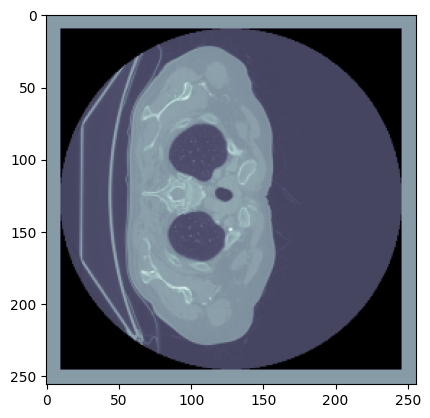

In [26]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid
pred = output_tensor.argmax(0)

for i in range(0, output_tensor.shape[3], 2):  # axial view
    plt.imshow(imgs[0,:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(pred[:,:,i]==0, pred[:,:,i])
    label_mask = np.ma.masked_where(mask[0,:,:,i]==0, mask[0,:,:,i])
    plt.imshow(mask_, alpha=0.1, cmap="autumn")
    #plt.imshow(label_mask, alpha=0.5, cmap="jet")  # Uncomment if you want to see the label

    # plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




In [25]:
HTML(animation.to_html5_video())  # convert the animation to a video


/home/joao.palhares/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/joao.palhares/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/joao.palhares/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
